In [1]:
import numpy as np
import pandas as pd
dataset=pd.read_csv('Predicting-House-Prices-In-Bengaluru-Train-Data.csv')
dataset.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Feature Engineering

In [6]:
def impute(x):
    data=str(x['total_sqft'])
    if '-' in data:
        #print(data)
        ans=(float(data.split('-')[0].strip())+float(data.split('-')[1].strip()))/2
        #print(ans)
        return ans
        #print(x[5]) 
    elif 'Sq. M' in data:
        ans=float(data[:data.find('Sq. M')])*10.7639
        return ans
    elif 'Sq. Y' in data:
        ans=float(data[:data.find('Sq. Y')])*9
        return ans
    elif 'Perch' in data:
        ans=float(data[:data.find('Perch')])*272.25
        return ans
    elif 'Acres' in data:
        ans=float(data[:data.find('Acres')])*43560
        return ans
    elif 'Cents' in data:
        ans=float(data[:data.find('Cents')])*435.61
        return ans
    elif 'Guntha' in data:
        ans=float(data[:data.find('Guntha')])*1089
        return ans
    elif 'Grounds' in data:
        ans=float(data[:data.find('Grounds')])*2400
        return ans
    else:
        return float(data)
dataset['total_sqft']=dataset.apply(impute,axis=1)

In [7]:
#Since Grare S Society is located only at Anantapura, the location for 568th row is imputed with Anantapura
dataset['location'].fillna('Anantapura',inplace=True)

In [8]:
#Calculate Size Score
# For BHK, multiply by 4*B+3+2
#For Bedroom, 4*B
#For RK, 4
def convertsize(x):
    if 'Bedroom' in str(x):
        x=x.split(' ')
        return int(x[0])*4
    elif 'BHK' in str(x):
        x=x.split(' ')
        return int(x[0])*4+5
    elif 'RK' in str(x):
        x=x.split(' ')
        return int(x[0])*4
    else:
        return x
dataset['size']=dataset['size'].apply(convertsize)   

In [9]:
imputable_dataset=dataset.loc[:,['size','total_sqft','bath','balcony']]

In [10]:
import fancyimpute

Using TensorFlow backend.


In [11]:
mice_imputation=fancyimpute.MICE(verbose=False)

In [12]:
imputable_dataset.head()

,size,total_sqft,bath,balcony
0,13.0,1056.0,2.0,1.0
1,16.0,2600.0,5.0,3.0
2,17.0,1440.0,2.0,3.0
3,17.0,1521.0,3.0,1.0
4,13.0,1200.0,2.0,1.0


In [13]:
imputable_dataset=mice_imputation.complete(imputable_dataset)


In [14]:
imputable_dataset=pd.DataFrame(imputable_dataset)
imputable_dataset.isnull().sum()


0    0
1    0
2    0
3    0
dtype: int64

In [15]:
dataset.drop(['size','total_sqft','bath','balcony'],inplace=True,axis=1)

In [16]:
imputable_dataset.columns=['size','total_sqft','bath','balcony']
dataset = pd.concat([dataset, imputable_dataset], axis=1, join='inner')

In [17]:
dataset['size']=dataset['size'].apply(lambda k:round(k))
dataset['bath']=dataset['bath'].apply(lambda k:round(k))
dataset['total_sqft']=dataset['total_sqft'].apply(lambda k:round(k))
dataset['balcony']=dataset['balcony'].apply(lambda k:round(k))

In [18]:
copy_dataset=dataset
copy_dataset.head()

,area_type,availability,location,society,price,size,total_sqft,bath,balcony
0,Super built-up Area,19-Dec,Electronic City Phase II,Coomee,39.07,13,1056,2,1
1,Plot Area,Ready To Move,Chikka Tirupathi,Theanmp,120.00,16,2600,5,3
2,Built-up Area,Ready To Move,Uttarahalli,NaN,62.00,17,1440,2,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,Soiewre,95.00,17,1521,3,1
4,Super built-up Area,Ready To Move,Kothanur,NaN,51.00,13,1200,2,1


In [19]:
lists=copy_dataset['location'].unique()
final_list=[]
for i in lists:
    temp_list=[]
    temp_list.append(i)
    temp_list.append(copy_dataset[copy_dataset['location']==str(i)].loc[:,'price'].mean())
    temp_list.append(copy_dataset[copy_dataset['location']==str(i)].loc[:,'price'].min())
    temp_list.append(copy_dataset[copy_dataset['location']==str(i)].loc[:,'price'].max())
    final_list.append(temp_list)
columns=['location','price','min_price','max_price']
location_data=pd.DataFrame(final_list,columns=columns)

In [20]:
location_data['price']=location_data['price'].apply(lambda k:round(k))

In [21]:
location_data.head()

,location,price,min_price,max_price
0,Electronic City Phase II,48,16.75,295.0
1,Chikka Tirupathi,115,80.27,150.0
2,Uttarahalli,61,30.00,330.0
3,Lingadheeranahalli,115,81.31,160.0
4,Kothanur,96,30.00,550.0


(array([ 643.,  385.,  134.,   50.,   40.,   13.,   10.,    4.,    8.,
           5.,    2.,    2.,    2.,    3.,    1.,    1.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    1.]),
 array([   15. ,    90.4,   165.8,   241.2,   316.6,   392. ,   467.4,
          542.8,   618.2,   693.6,   769. ,   844.4,   919.8,   995.2,
         1070.6,  1146. ,  1221.4,  1296.8,  1372.2,  1447.6,  1523. ,
         1598.4,  1673.8,  1749.2,  1824.6,  1900. ]),
 <a list of 25 Patch objects>)

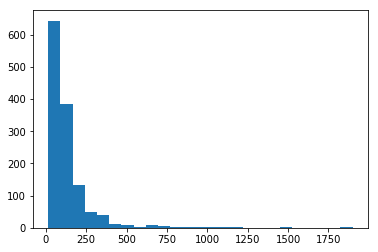

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
arr=plt.hist(location_data['price'],bins=25)
arr

In [23]:
from bisect import bisect
def set_location_code(x):
    pos=bisect(arr[1],x)
    if pos==0:
        return 1
    elif pos==26:
        return 25
    else:
        return pos
    

In [24]:
location_data['location_code']=location_data['price'].apply(set_location_code)

In [25]:
location_data_copy=location_data
location_data_copy.head()

,location,price,min_price,max_price,location_code
0,Electronic City Phase II,48,16.75,295.0,1
1,Chikka Tirupathi,115,80.27,150.0,2
2,Uttarahalli,61,30.00,330.0,1
3,Lingadheeranahalli,115,81.31,160.0,2
4,Kothanur,96,30.00,550.0,2


In [26]:
import re
pattern = re.compile(r'\s+')


In [27]:
location_data['location']=location_data['location'].apply(lambda sentence: re.sub(pattern, '', sentence))

In [28]:
location_data['location']=location_data['location'].apply(lambda x:x.lower())
location_data.head()

,location,price,min_price,max_price,location_code
0,electroniccityphaseii,48,16.75,295.0,1
1,chikkatirupathi,115,80.27,150.0,2
2,uttarahalli,61,30.00,330.0,1
3,lingadheeranahalli,115,81.31,160.0,2
4,kothanur,96,30.00,550.0,2


In [29]:
def assign_location_code(x):
    return location_data[location_data['location']==str(x)].iloc[0,4]
def assign_mean_price(x):
    return location_data[location_data['location']==str(x)].iloc[0,1]
def assign_min_price(x):
    return location_data[location_data['location']==str(x)].iloc[0,2]
def assign_max_price(x):
    return location_data[location_data['location']==str(x)].iloc[0,3]


In [30]:
copy_dataset['location']=copy_dataset['location'].apply(lambda sentence: re.sub(pattern, '', sentence))
copy_dataset['location']=copy_dataset['location'].apply(lambda x:x.lower())

copy_dataset['location_code']=copy_dataset['location'].apply(assign_location_code)
copy_dataset['mean_price']=copy_dataset['location'].apply(assign_mean_price)
copy_dataset['min_price']=copy_dataset['location'].apply(assign_min_price)
copy_dataset['max_price']=copy_dataset['location'].apply(assign_max_price)


In [31]:
copy_dataset.head()

,area_type,availability,location,society,price,size,total_sqft,bath,balcony,location_code,mean_price,min_price,max_price
0,Super built-up Area,19-Dec,electroniccityphaseii,Coomee,39.07,13,1056,2,1,1,48,16.75,295.0
1,Plot Area,Ready To Move,chikkatirupathi,Theanmp,120.00,16,2600,5,3,2,115,80.27,150.0
2,Built-up Area,Ready To Move,uttarahalli,NaN,62.00,17,1440,2,3,1,61,30.00,330.0
3,Super built-up Area,Ready To Move,lingadheeranahalli,Soiewre,95.00,17,1521,3,1,2,115,81.31,160.0
4,Super built-up Area,Ready To Move,kothanur,NaN,51.00,13,1200,2,1,2,96,30.00,550.0


In [32]:
def code_society(x):
    if x!=x:
        return 'no'
    else:
        return 'yes'
copy_dataset['society']=copy_dataset['society'].apply(code_society)

In [33]:
copy_dataset['society'].unique()

array(['yes', 'no'], dtype=object)

In [34]:
new=['Ready To Move','Immediate Possession']
def change_availability(x):
    if str(x) not in new:
        return 'dated'
    else:
        return x
copy_dataset['availability']=copy_dataset['availability'].apply(change_availability)

In [35]:
copy_dataset['availability'].unique()

array(['dated', 'Ready To Move', 'Immediate Possession'], dtype=object)

In [36]:
build=copy_dataset.drop(['location'],axis=1)

In [37]:
copy_dataset['society'].unique()

array(['yes', 'no'], dtype=object)

In [38]:
build.head()

,area_type,availability,society,price,size,total_sqft,bath,balcony,location_code,mean_price,min_price,max_price
0,Super built-up Area,dated,yes,39.07,13,1056,2,1,1,48,16.75,295.0
1,Plot Area,Ready To Move,yes,120.00,16,2600,5,3,2,115,80.27,150.0
2,Built-up Area,Ready To Move,no,62.00,17,1440,2,3,1,61,30.00,330.0
3,Super built-up Area,Ready To Move,yes,95.00,17,1521,3,1,2,115,81.31,160.0
4,Super built-up Area,Ready To Move,no,51.00,13,1200,2,1,2,96,30.00,550.0


In [39]:
build['society'].unique()

array(['yes', 'no'], dtype=object)

In [40]:
build_labels=build.iloc[:,3]

In [41]:
build_labels.head()

0     39.07
1    120.00
2     62.00
3     95.00
4     51.00
Name: price, dtype: float64

In [42]:
build=build.drop(['price','mean_price','min_price','max_price'],axis=1)
build.head()

,area_type,availability,society,size,total_sqft,bath,balcony,location_code
0,Super built-up Area,dated,yes,13,1056,2,1,1
1,Plot Area,Ready To Move,yes,16,2600,5,3,2
2,Built-up Area,Ready To Move,no,17,1440,2,3,1
3,Super built-up Area,Ready To Move,yes,17,1521,3,1,2
4,Super built-up Area,Ready To Move,no,13,1200,2,1,2


In [43]:
build['society'].unique()

array(['yes', 'no'], dtype=object)

# Exploratory Data Analysis

In [44]:
build.head()

,area_type,availability,society,size,total_sqft,bath,balcony,location_code
0,Super built-up Area,dated,yes,13,1056,2,1,1
1,Plot Area,Ready To Move,yes,16,2600,5,3,2
2,Built-up Area,Ready To Move,no,17,1440,2,3,1
3,Super built-up Area,Ready To Move,yes,17,1521,3,1,2
4,Super built-up Area,Ready To Move,no,13,1200,2,1,2


Append price to the dataset


In [45]:
build=pd.concat([build,build_labels],axis=1)

In [46]:
build.head()

,area_type,availability,society,size,total_sqft,bath,balcony,location_code,price
0,Super built-up Area,dated,yes,13,1056,2,1,1,39.07
1,Plot Area,Ready To Move,yes,16,2600,5,3,2,120.00
2,Built-up Area,Ready To Move,no,17,1440,2,3,1,62.00
3,Super built-up Area,Ready To Move,yes,17,1521,3,1,2,95.00
4,Super built-up Area,Ready To Move,no,13,1200,2,1,2,51.00


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 2418.,     0.,     0.,    87.,     0.,     0.,  2025.,     0.,
            0.,  8790.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

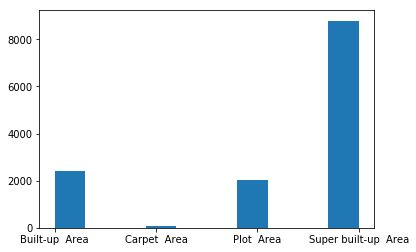

In [48]:
plt.hist(build['area_type'])

(array([    16.,      0.,      0.,      0.,      0.,  10581.,      0.,
             0.,      0.,   2723.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

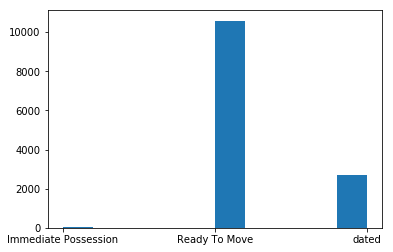

In [49]:
plt.hist(build['availability'])

(array([ 5502.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7818.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

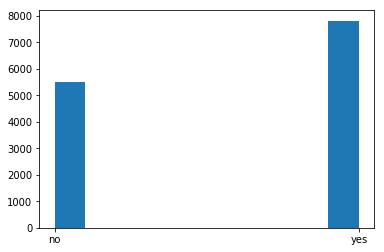

In [50]:
plt.hist(build['society'])

In [51]:
build.corr()

,size,total_sqft,bath,balcony,location_code,price
size,1.000000,0.038494,0.825657,0.260815,0.177317,0.320136
total_sqft,0.038494,1.000000,0.053116,0.008498,0.025122,0.048995
bath,0.825657,0.053116,1.000000,0.198720,0.246023,0.455528
balcony,0.260815,0.008498,0.198720,1.000000,0.074450,0.115670
location_code,0.177317,0.025122,0.246023,0.074450,1.000000,0.615089
price,0.320136,0.048995,0.455528,0.115670,0.615089,1.000000


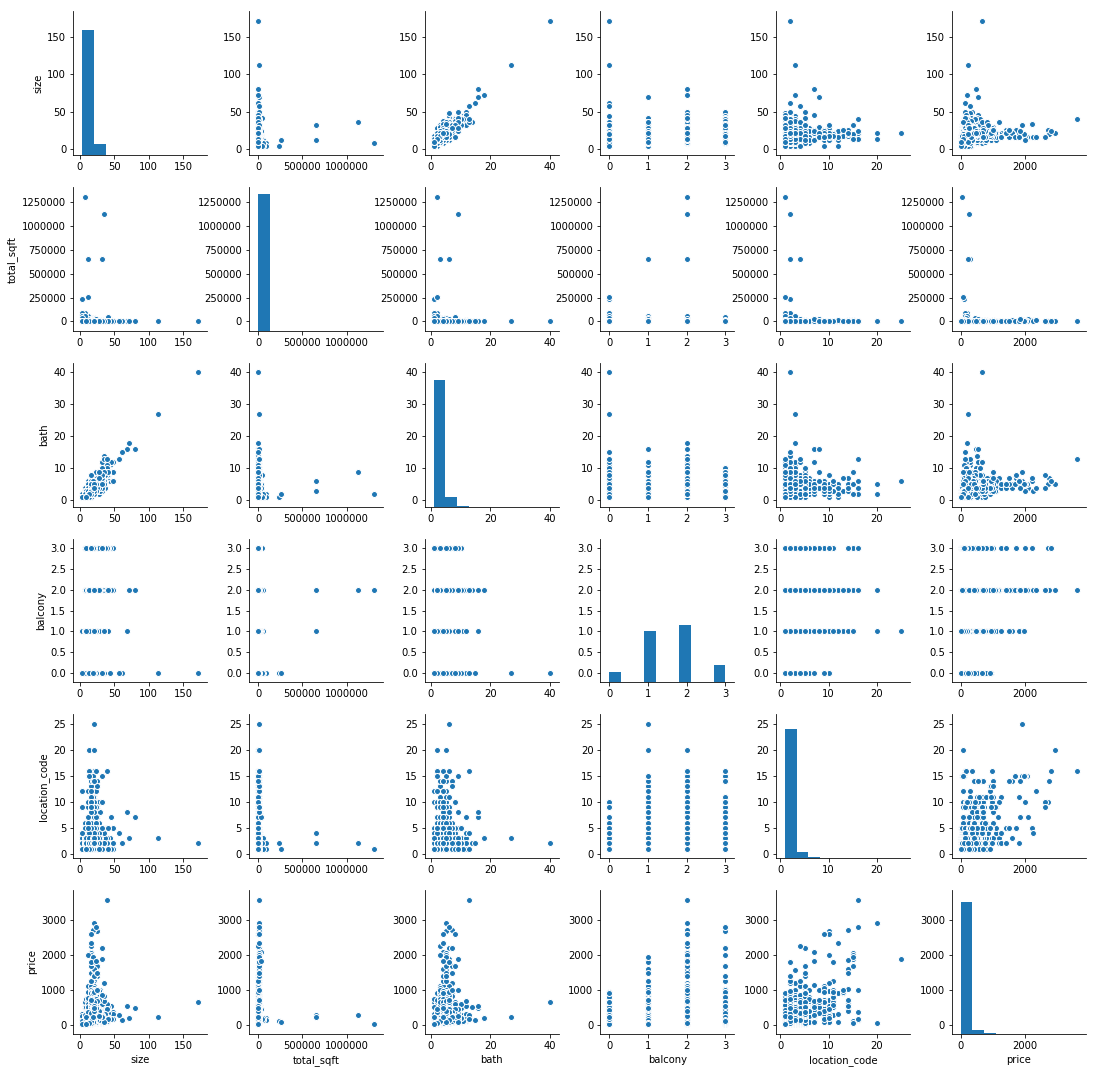

In [52]:
import seaborn as sns
sns.pairplot(build)

# EDA observations

* Immediate possession is less, so we have to club this together with ready to move
* Do one way ANOVA on Area_type Vs Price , Availability Vs Price and Society Vs Price
* Size and bath are correlated heavily but correlation of bath with price is higher than that of size with price
* total_sqft is not all correlated with price
* Location code is the highest correlated measure with price

# Statistical tests

In [53]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [54]:
cw_lm=ols('price ~ C(area_type)', data=build).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=1))

                   df        sum_sq       mean_sq           F         PR(>F)
C(area_type)      3.0  2.222185e+07  7.407283e+06  360.824833  2.583085e-225
Residual      13316.0  2.733609e+08  2.052875e+04         NaN            NaN


In [55]:
cw_lm=ols('price ~ C(availability)', data=build).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=1))

                      df        sum_sq        mean_sq        F    PR(>F)
C(availability)      2.0  3.516719e+05  175835.942512  7.93144  0.000361
Residual         13317.0  2.952310e+08   22169.484812      NaN       NaN


In [56]:
cw_lm=ols('price ~ C(society)', data=build).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=1))

                 df        sum_sq       mean_sq           F        PR(>F)
C(society)      1.0  2.338597e+06  2.338597e+06  106.209915  8.219875e-25
Residual    13318.0  2.932441e+08  2.201863e+04         NaN           NaN


We see that, as per ANOVA, the mean house price is significantly different for each group across all three categorical predictors. So we keep all three predictors in the model

# Feature Cleaning

In [57]:
build['availability'].unique()

array(['dated', 'Ready To Move', 'Immediate Possession'], dtype=object)

In [58]:
def change_availab(x):
    if x=='Immediate Possession':
        return 'Ready To Move'
    else:
        return x
build['availability']=build['availability'].apply(change_availab)

In [59]:
build['availability'].unique()

array(['dated', 'Ready To Move'], dtype=object)

To avoid multicollinearity drop size from the dataset 

In [60]:
build.drop('size',axis=1,inplace=True)

In [61]:
build.head()

,area_type,availability,society,total_sqft,bath,balcony,location_code,price
0,Super built-up Area,dated,yes,1056,2,1,1,39.07
1,Plot Area,Ready To Move,yes,2600,5,3,2,120.00
2,Built-up Area,Ready To Move,no,1440,2,3,1,62.00
3,Super built-up Area,Ready To Move,yes,1521,3,1,2,95.00
4,Super built-up Area,Ready To Move,no,1200,2,1,2,51.00


Now drop the price column

In [62]:
build.drop('price',axis=1,inplace=True)

Create one hot encoding for categorical variables

In [63]:
build=pd.get_dummies(build,drop_first=True)

In [64]:
build.head()

,total_sqft,bath,balcony,location_code,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_dated,society_yes
0,1056,2,1,1,0,0,1,1,1
1,2600,5,3,2,0,1,0,0,1
2,1440,2,3,1,0,0,0,0,0
3,1521,3,1,2,0,0,1,0,1
4,1200,2,1,2,0,0,1,0,0


# Build Models

In [65]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [66]:
build_labels1=np.log10(build_labels)
build_labels2=np.log(build_labels)

In [67]:
build_labels

0         39.07
1        120.00
2         62.00
3         95.00
4         51.00
5         38.00
6        204.00
7        600.00
8         63.25
9        370.00
10        70.00
11       295.00
12        38.00
13        40.00
14       148.00
15        73.50
16        48.00
17        60.00
18       290.00
19        48.00
20        15.00
21       122.00
22       380.00
23       103.00
24        25.25
25        56.00
26        23.10
27        81.00
28        48.77
29        47.00
          ...  
13290    450.00
13291     26.00
13292     63.93
13293    195.00
13294     80.00
13295    112.00
13296    140.00
13297     52.00
13298     60.00
13299    154.50
13300    145.00
13301     71.50
13302     48.00
13303     70.00
13304     40.14
13305    220.00
13306    325.00
13307    134.00
13308    142.00
13309     92.13
13310     52.71
13311    250.00
13312     47.00
13313     57.00
13314    112.00
13315    231.00
13316    400.00
13317     60.00
13318    488.00
13319     17.00
Name: price, Length: 133

In [68]:
from sklearn import preprocessing

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# import math
# def rmse(y,y_pred):
#     y=np.log10(np.exp(y))
#     y_pred=np.log10(np.exp(y_pred))
#     return 1-math.sqrt(mean_squared_error(y,y_pred))
# rmsle=make_scorer(rmse)

In [70]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [71]:
gbr=GradientBoostingRegressor(loss='huber',n_estimators=400,max_depth=5)
scores = cross_val_score(gbr, build, build_labels1, cv=10,scoring='neg_mean_squared_error')

In [72]:
import math
1-math.sqrt(abs(scores).mean())

0.8680155268947549

In [73]:
so=[]
for i in scores:
    so.append(1-math.sqrt(abs(i)))
print(so)
print('-----')
sum(so)/len(so)

[0.8691121137815461, 0.8643969859462353, 0.8740446551296464, 0.8723880597978323, 0.8681209689197867, 0.8561742537973889, 0.8618868131731681, 0.8697538671046221, 0.8648403618808964, 0.8810702743197689]
-----


0.8681788353850891

In [74]:
xgb=XGBRegressor(n_estimators=400,max_depth=5)
scores = cross_val_score(xgb, build, build_labels1, cv=10,scoring='neg_mean_squared_error')
1-math.sqrt(abs(scores).mean())

0.8675595044886155

In [75]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor()
scores = cross_val_score(rfr, build, build_labels1, cv=10,scoring='neg_mean_squared_error')
1-math.sqrt(abs(scores).mean())

0.8573204009300798

In [76]:
from sklearn.neural_network import MLPRegressor
mlpr=MLPRegressor(learning_rate='adaptive',hidden_layer_sizes=(1500, ),activation='logistic')
scores = cross_val_score(mlpr, build, build_labels1, cv=10,scoring='neg_mean_squared_error')
1-math.sqrt(abs(scores).mean())

0.8379529476560419

We see that Gradient Boosting Regressor and XGBoost have yielded the best results. Since XGBoost is a parallelized version of Gradient Boosting Regressor le us tune the parameters of XGBoost

# XGBoost Parameter Tuning

In [77]:
 from sklearn.model_selection import GridSearchCV

In [78]:
model=XGBRegressor()
parameters={'max_depth':range(1,11),'learning_rate':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
            'n_estimators':[10,50,100,150,200,250,300,350,400,450],'booster':['gbtree', 'gblinear', 'dart'],
            }

As we see we have 540 parameter combinations and if a single model takes 2 minutes to train, then we have to wait for 1080 minutes to get the result. It is clearly not possible. So Let us find the best parameter across the 4 groups and combine them together to build the final model. It may not be the global optimum.


We can tune the model in two ways.

1. Additive tuning   - Use the estimated best parameters of the previous groups as the model parameter before tuning successive                        groups' parameters
2. Standalone tuning - Tune the group parameters individually and combine them only at last

# Additive Tuning

Tune Max_depth

In [79]:
parameters={'max_depth':range(1,11)}

In [80]:
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)

In [81]:
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   39.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [82]:
tuned_model.best_params_

{'max_depth': 7}

Tune Learning Rate

In [85]:
model=XGBRegressor(max_depth=7)
parameters={'learning_rate':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   35.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [86]:
tuned_model.best_params_

{'learning_rate': 0.1}

Tune number of Estimators

In [88]:
model=XGBRegressor(max_depth==7,learning_rate=0.1)
parameters={'n_estimators':[10,50,100,150,200,250,300,350,400,450]}
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400, 450]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [89]:
tuned_model.best_params_

{'n_estimators': 100}

Tune booster

In [93]:
model=XGBRegressor(max_depth=7,learning_rate=0.1,n_estimators=100)
parameters={'booster':['gbtree', 'gblinear', 'dart']}
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'booster': ['gbtree', 'gblinear', 'dart']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [94]:
tuned_model.best_params_

{'booster': 'dart'}

As we see the final model parameters we have got after addditive tuning are as follows:
1. max_depth=7
2. learning_rate=0.1
3. n_estimators=100
4. booster=dart


In [95]:
# Build this model
xgb=XGBRegressor(n_estimators=100,max_depth=7,learning_rate=0.1,booster='dart')
scores = cross_val_score(xgb, build, build_labels1, cv=10,scoring='neg_mean_squared_error')
1-math.sqrt(abs(scores).mean())

0.8678996344181332

There is not much of an improvement when compared to our baseline model

# Standalone tuning

In [90]:
model=XGBRegressor()
parameters={'n_estimators':[10,50,100,150,200,250,300,350,400,450]}
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   33.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400, 450]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [91]:
tuned_model.best_params_

{'n_estimators': 450}

In [96]:
model=XGBRegressor()
parameters={'learning_rate':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [97]:
tuned_model.best_params_

{'learning_rate': 0.3}

In [98]:
model=XGBRegressor()
parameters={'booster':['gbtree', 'gblinear', 'dart']}
tuned_model = GridSearchCV(model, parameters,scoring='neg_mean_squared_error',verbose=1)
tuned_model.fit(build, build_labels1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'booster': ['gbtree', 'gblinear', 'dart']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [99]:
tuned_model.best_params_

{'booster': 'dart'}

In [100]:
# Now run the model with these parameters

In [101]:
xgb=XGBRegressor(n_estimators=450,max_depth=7,learning_rate=0.3,booster='dart')
scores = cross_val_score(xgb, build, build_labels1, cv=10,scoring='neg_mean_squared_error')
1-math.sqrt(abs(scores).mean())

0.8592882400711099

Let us go with the additively tuned parameters as our final model parameters

# Build final model

In [102]:
final_model=XGBRegressor(n_estimators=100,max_depth=7,learning_rate=0.1,booster='dart')
final_model.fit(build,build_labels1)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Predict on test set

In [103]:
test_set=pd.read_csv('Predicting-House-Prices-In-Bengaluru-Test-Data.csv')

In [104]:
test_set.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [105]:
test_set.drop(['price'],inplace=True,axis=1)

In [106]:
test_set.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0


In [107]:
test_set.isnull().sum()

area_type         0
availability      0
location          0
size              2
society         626
total_sqft        0
bath              7
balcony          69
dtype: int64

In [108]:
test_set['location']=test_set['location'].apply(lambda sentence: re.sub(pattern, '', sentence))
test_set['location']=test_set['location'].apply(lambda x:x.lower())

test_set.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,brookefield,2 BHK,Roeekbl,1225,2.0,2.0
1,Plot Area,Ready To Move,akshayanagar,9 Bedroom,NaN,2400,9.0,2.0
2,Plot Area,18-Apr,hennurroad,4 Bedroom,Saandtt,1650,5.0,2.0
3,Super built-up Area,Ready To Move,kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0
4,Super built-up Area,Ready To Move,konanakunte,2 BHK,AmageSa,1161,2.0,1.0


In [109]:
test_set['total_sqft']=test_set.apply(impute,axis=1)

In [110]:
test_set['size']=test_set['size'].apply(convertsize)

In [111]:
imputable=test_set.loc[:,['size','total_sqft','bath','balcony']]
imp=fancyimpute.MICE(verbose=False)
df1=imp.complete(imputable)

In [112]:
df1=pd.DataFrame(df1)
df1.head()

,0,1,2,3
0,13.0,1225.0,2.0,2.0
1,36.0,2400.0,9.0,2.0
2,16.0,1650.0,5.0,2.0
3,17.0,1322.0,3.0,1.0
4,13.0,1161.0,2.0,1.0


In [113]:
df1.columns=['size','total_sqft','bath','balcony']

In [114]:
df1.head()

,size,total_sqft,bath,balcony
0,13.0,1225.0,2.0,2.0
1,36.0,2400.0,9.0,2.0
2,16.0,1650.0,5.0,2.0
3,17.0,1322.0,3.0,1.0
4,13.0,1161.0,2.0,1.0


In [115]:
test_set.drop(['size','total_sqft','bath','balcony'],axis=1,inplace=True)

In [116]:
test_set=pd.concat([test_set,df1],axis=1)

In [117]:
test_set.head()
test_set.dtypes

area_type        object
availability     object
location         object
society          object
size            float64
total_sqft      float64
bath            float64
balcony         float64
dtype: object

In [118]:
a=set(location_data['location'])
b=set(test_set['location'].unique())
manipulable_data=[]
for i in b:
    if i not in a:
        manipulable_data.append(i) 


In [119]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [120]:
choices=list(location_data['location'])
list_of_loc=[]
for i in manipulable_data:
    temp=[]
    temp.append(i)
    result=process.extractOne(i, choices)
    temp.append(result[0])
    temp.append(str(result[1])+'%')
    list_of_loc.append(temp)
columns=['original_location','matched_location','percentage match']
matched_location_data=pd.DataFrame(list_of_loc)
matched_location_data.columns=columns

In [121]:
matched_location_data

,original_location,matched_location,percentage match
0,15thblockhbrlayout,5thblockhbrlayout,97%
1,padarayanapura,anarayanapura,89%
2,inasappalayout,dasappalayout,89%
3,sipcot1,oldairportroad,51%
4,"j.p.nagar6thphase,sarakkinagar",j.p.nagar6thphase.sarakkinagar,100%
5,kasofficerscolony,nrcolony,79%
6,santoshnagar,vasanthnagar,83%
7,agaratataguni,nagarajagarden,59%
8,#name?,mangammanapalya,68%
9,chinnapagarden,nanjappagarden,79%


In [122]:
def change_location(x):
    if x in manipulable_data:
        return matched_location_data[matched_location_data['original_location']==x].iloc[0,1]
    else:
        return x
test_set['location']=test_set['location'].apply(change_location)

In [123]:
test_set.head()

,area_type,availability,location,society,size,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,brookefield,Roeekbl,13.0,1225.0,2.0,2.0
1,Plot Area,Ready To Move,akshayanagar,NaN,36.0,2400.0,9.0,2.0
2,Plot Area,18-Apr,hennurroad,Saandtt,16.0,1650.0,5.0,2.0
3,Super built-up Area,Ready To Move,kodichikkanahalli,Winerri,17.0,1322.0,3.0,1.0
4,Super built-up Area,Ready To Move,konanakunte,AmageSa,13.0,1161.0,2.0,1.0


In [124]:
# location_data.head()
# b=set(test_set['location'])
# a=set(location_data['location'])
# for i in b:
#     if i not in a:
#         print(i)
test_set['location_code']=test_set['location'].apply(assign_location_code)
test_set['mean_price']=test_set['location'].apply(assign_mean_price)
test_set['min_price']=test_set['location'].apply(assign_min_price)
test_set['max_price']=test_set['location'].apply(assign_max_price)

test_set['society']=test_set['society'].apply(code_society)

test_set['availability']=test_set['availability'].apply(change_availability)

In [125]:
test_set.drop('location',axis=1,inplace=True)
test_set.head()

,area_type,availability,society,size,total_sqft,bath,balcony,location_code,mean_price,min_price,max_price
0,Super built-up Area,Ready To Move,yes,13.0,1225.0,2.0,2.0,2,118,48.0,425.0
1,Plot Area,Ready To Move,no,36.0,2400.0,9.0,2.0,1,85,38.0,200.0
2,Plot Area,dated,yes,16.0,1650.0,5.0,2.0,2,104,23.0,515.0
3,Super built-up Area,Ready To Move,yes,17.0,1322.0,3.0,1.0,1,70,18.0,200.0
4,Super built-up Area,Ready To Move,yes,13.0,1161.0,2.0,1.0,3,189,58.0,511.0


In [126]:
test_set.drop(['mean_price','min_price','max_price'],axis=1,inplace=True)

In [127]:
test_set.drop('size',axis=1,inplace=True)
test_set.head()

,area_type,availability,society,total_sqft,bath,balcony,location_code
0,Super built-up Area,Ready To Move,yes,1225.0,2.0,2.0,2
1,Plot Area,Ready To Move,no,2400.0,9.0,2.0,1
2,Plot Area,dated,yes,1650.0,5.0,2.0,2
3,Super built-up Area,Ready To Move,yes,1322.0,3.0,1.0,1
4,Super built-up Area,Ready To Move,yes,1161.0,2.0,1.0,3


In [128]:
test_set['availability']=test_set['availability'].apply(change_availab)

In [129]:
test_set=pd.get_dummies(test_set,drop_first=True)

In [130]:
build.head()

,total_sqft,bath,balcony,location_code,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_dated,society_yes
0,1056,2,1,1,0,0,1,1,1
1,2600,5,3,2,0,1,0,0,1
2,1440,2,3,1,0,0,0,0,0
3,1521,3,1,2,0,0,1,0,1
4,1200,2,1,2,0,0,1,0,0


In [131]:
test_set.head()

,total_sqft,bath,balcony,location_code,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_dated,society_yes
0,1225.0,2.0,2.0,2,0,0,1,0,1
1,2400.0,9.0,2.0,1,0,1,0,0,0
2,1650.0,5.0,2.0,2,0,1,0,1,1
3,1322.0,3.0,1.0,1,0,0,1,0,1
4,1161.0,2.0,1.0,3,0,0,1,0,1


In [132]:
test_set['bath']=test_set['bath'].apply(lambda k:round(k))
test_set['total_sqft']=test_set['total_sqft'].apply(lambda k:round(k))
test_set['balcony']=test_set['balcony'].apply(lambda k:round(k))
test_set.head()

,total_sqft,bath,balcony,location_code,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_dated,society_yes
0,1225,2,2,2,0,0,1,0,1
1,2400,9,2,1,0,1,0,0,0
2,1650,5,2,2,0,1,0,1,1
3,1322,3,1,1,0,0,1,0,1
4,1161,2,1,3,0,0,1,0,1


In [133]:
build.head()

,total_sqft,bath,balcony,location_code,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_dated,society_yes
0,1056,2,1,1,0,0,1,1,1
1,2600,5,3,2,0,1,0,0,1
2,1440,2,3,1,0,0,0,0,0
3,1521,3,1,2,0,0,1,0,1
4,1200,2,1,2,0,0,1,0,0


In [134]:
predict_ans=final_model.predict(test_set)

In [135]:
predict_ans.shape

(1480,)

In [136]:
predict_ans

array([ 1.79858756,  2.41069984,  2.38392496, ...,  1.74061751,
        1.60107493,  1.7643801 ], dtype=float32)

In [137]:
build.shape

(13320, 9)

In [138]:
np.log(10)

2.3025850929940459

In [139]:
predict_ans1=predict_ans*np.log(10)

In [140]:
predict_ans2=np.exp(predict_ans1)

In [141]:
predict_ans2

array([  62.8908577 ,  257.45419312,  242.06108093, ...,   55.03227234,
         39.90938187,   58.12730026], dtype=float32)

In [142]:
predicted_house_prices=pd.read_csv('Predicting-House-Prices-In-Bengaluru-Test-Data.csv')

In [143]:
predicted_house_prices.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [144]:
predicted_house_prices.drop('price',inplace=True,axis=1)

In [145]:
ans_df=pd.DataFrame(predict_ans2)
ans_df.columns=['price']
ans_df.head()

,price
0,62.890858
1,257.454193
2,242.061081
3,61.814671
4,84.076324


In [146]:
predicted_house_prices=pd.concat([predicted_house_prices,ans_df],axis=1)

In [147]:
predicted_house_prices.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,62.890858
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,257.454193
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,242.061081
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,61.814671
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,84.076324


In [148]:
predicted_house_prices['price']=predicted_house_prices['price'].apply(lambda x:round(x,2))

In [149]:
predicted_house_prices.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,62.89
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,257.45
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,242.06
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,61.81
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,84.08


In [151]:
writer = pd.ExcelWriter('predicted_house_prices_final_output.xlsx')
predicted_house_prices.to_excel(writer,'Answer')
writer.save()

In [152]:
predicted_house_prices['price'].mean()

104.39102027027032

In [153]:
predicted_house_prices['price'].min()

15.449999999999999

In [154]:
predicted_house_prices['price'].max()

1160.8299999999999